In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, Flatten, concatenate
from tensorflow.keras.layers import Conv1D, LSTM, Embedding, SpatialDropout1D
from tensorflow.keras.optimizers import Adadelta, Adam, RMSprop, SGD, Adagrad
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import LambdaCallback

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MultiLabelBinarizer

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

import gc


sns.set()
pd.set_option('display.max_column', 50)

In [2]:
PATH = r"hh.csv"

In [3]:
df = pd.read_csv(PATH)
dataset = pd.DataFrame()

In [42]:
df.head()

,Unnamed: 0,"Пол, возраст",ЗП,Ищет работу на должность:,Город,Занятость,График,Опыт (двойное нажатие для полной версии),Последенее/нынешнее место работы,Последеняя/нынешняя должность,Образование и ВУЗ,Обновление резюме,Авто,sex,age,experience,salary
0,0,"Мужчина , 29 лет , родился 16 мая 1989",40000 руб.,Специалист по поддержке чата(support team) дом...,"Новороссийск , готов к переезду (Анапа, Геленд...",полная занятость,полный день,Опыт работы 3 года 9 месяцев Специалист по по...,"ООО ""Гольфстрим""",Генеральный директор,Высшее образование 2011 Международный юридиче...,26.04.2019 08:04,Не указано,1,29,270,40000.0
1,1,"Мужчина , 38 лет , родился 25 мая 1980",40000 руб.,Системный администратор,"Новосибирск , м. Березовая роща , не готов к ...",полная занятость,полный день,Опыт работы 11 лет 11 месяцев Системный админ...,ООО «Завод модульных технологий»,Системный администратор,Высшее образование 2002 Новосибирский государс...,26.04.2019 04:30,Не указано,1,38,939,40000.0
2,2,"Мужчина , 35 лет , родился 14 июня 1983",300000 руб.,DevOps TeamLead / DevOps архитектор,"Москва , готов к переезду , готов к редким ком...",полная занятость,полный день,Опыт работы 12 лет 11 месяцев DevOps TeamLead...,Банк ВТБ (ПАО),Начальник отдела методологии разработки (DevOp...,DevOps TeamLead / DevOps архитектор 300 000 ру...,09.04.2019 14:40,Не указано,1,35,869,300000.0
3,3,"Мужчина , 33 года , родился 2 августа 1985",180000 руб.,Руководитель IT отдела,"Москва , м. Щукинская , не готов к переезду ,...","частичная занятость, полная занятость","удаленная работа, полный день",Опыт работы 15 лет 10 месяцев Руководитель IT...,"""Ай-Теко"", ведущий российский системный интегр...",Старший системный администратор,Руководитель IT отдела 180 000 руб. Информацио...,09.04.2019 14:39,Имеется собственный автомобиль,1,33,1266,180000.0
4,4,"Мужчина , 22 года , родился 1 сентября 1996",40000 руб.,Junior Developer,"Москва , м. Юго-Западная , не готов к переезд...","стажировка, частичная занятость, проектная работа","гибкий график, удаленная работа",Опыт работы 1 год 1 месяц Junior Developer 40...,R-Style SoftLab,Менеджер IT-проектов,Junior Developer 40 000 руб. Информационные те...,29.03.2019 12:40,Не указано,1,22,78,40000.0


In [4]:
def parseSexAndAge(value):
    sex = 0
    age = 0
    if value[0] == "М":
        sex = 1
    age = int( re.split("лет|год",value)[0].split(",")[1].strip() )
    return pd.Series([sex, age])

def ageToVector(value):
    age = min(7, max(0, int(value) // 10))
    return pd.Series(utils.to_categorical(age,8))

df[["sex", "age"]] = df["Пол, возраст"].apply(parseSexAndAge)
dataset["sex"] = df["sex"]
ageScaler = StandardScaler()
dataset["age_sc"] = ageScaler.fit_transform(df["age"].values[...,None])
dataset[["age_0", "age_1", "age_2", "age_3", "age_4", "age_5", "age_6", "age_7"]] = df["age"].apply(ageToVector)

In [5]:
def parseEmployment(series):
    employment = series.str.split(", ")
    mbl = MultiLabelBinarizer()
    mbl.fit(employment)
    employment = mbl.transform(employment)
    columns = mbl.classes_
    return pd.DataFrame(employment, columns=columns)

dataset = pd.concat( [dataset, parseEmployment(df["Занятость"])], axis=1 )

In [6]:
def parseSchedule(series):
    schedule = series.str.split(", ")
    mbl = MultiLabelBinarizer()
    mbl.fit(schedule)
    schedule = mbl.transform(schedule)
    columns = mbl.classes_
    return pd.DataFrame(schedule, columns=columns)

dataset = pd.concat( [dataset, parseEmployment(df["График"])], axis=1 )

In [7]:
def parseExperience(value):
    if value != value:
        return 0
    patern = "[\d]+ год|[\d]+ мес|[\d]+ лет"
    experience = 0
    for exp in re.findall(patern, value):
        if "год" in exp:
            experience += int(exp[:-4]) * 12
        if "лет" in exp:
            experience += int(exp[:-4]) * 12
        if "мес" in exp:
            experience += int(exp[:-4])
    return experience

def experienceToVector(exp):
    experience = 0
    if exp < 6:
        experience = 0
    elif exp < 12:
        experience = 1
    elif exp < 36:
        experience = 2
    elif exp < 60:
        experience = 3
    elif exp < 120:
        experience = 4
    elif exp >= 120:
        experience = 5
    return pd.Series(utils.to_categorical(experience, num_classes=6))        

df["experience"] = df["Опыт (двойное нажатие для полной версии)"].apply(parseExperience)
experienceScaler = StandardScaler()
dataset["exp_sc"] = experienceScaler.fit_transform(df["experience"].values[...,None])
dataset[["exp_0", "exp_1", "exp_2", "exp_3", "exp_4", "exp_5"]] = df["experience"].apply(experienceToVector)

In [8]:
def parseCity(value):
    milCities = ["Новосибирск", "Екатеринбург", "Нижний Новгород", "Казань", "Челябинск", "Омск", "Самара", 
                 "Ростов-на-Дону", "Уфа", "Красноярск", "Пермь", "Воронеж", "Волгоград", "Краснодар"]
    msk = 0
    spb = 0
    mil = 0
    oth = 0    
    
    if value == "Москва":
        msk = 1
    elif value == "Санкт-Петербург":
        spb = 1
    elif value in milCities:
        mil = 1
    else:
        oth = 1
    
    return pd.Series([msk, spb, mil, oth])
    
    
dataset[["msk", "spb", "mil", "oth"]] = df["Город"].str.split(",").str[0].str.strip().apply(parseCity)

In [9]:
def parseEducation(value):
    if "неоконченное высшее" in value.lower():
        return pd.Series([0, 0, 1, 0])
    if "высшее" in value.lower():
        return pd.Series([1, 0, 0, 0])
    if "среднее специальное" in value.lower():
        return pd.Series([0, 1, 0, 0])
    if "среднее образование" in value.lower():
        return pd.Series([0, 0, 0, 1])
    return pd.Series([0, 0, 0, 0])

dataset[["edu_0", "edu_1", "edu_2", "edu_3"]] = df["Образование и ВУЗ"].apply(parseEducation)

In [10]:
rate = {'руб.' : 1, 'EUR' : 75.66, 'USD' : 70.34, 'KZT' : 0.1526, 'грн.' : 1.91, 
        'бел.руб.' : 26.21, 'AZN' : 41.38, 'KGS' : 0.821, 'сум' : 0.00627}

df["salary"] = df["ЗП"].str.split(" ").str[0].astype(int) * df["ЗП"].str.split(" ").str[1].map(rate)
salaryScaler = StandardScaler()
dataset["salary_sc"] = salaryScaler.fit_transform(df["salary"].values[...,None])

In [43]:
dataset.head()

,sex,age_sc,age_0,age_1,age_2,age_3,age_4,age_5,age_6,age_7,волонтерство,полная занятость,проектная работа,стажировка,частичная занятость,вахтовый метод,гибкий график,полный день,сменный график,удаленная работа,exp_sc,exp_0,exp_1,exp_2,exp_3,exp_4,exp_5,msk,spb,mil,oth,edu_0,edu_1,edu_2,edu_3,salary_sc
0,1,-0.397626,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,1,0,0,-0.150780,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0,1,1,0,0,0,-0.286309
1,1,0.710040,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,1,0,0,-0.119943,0.0,0.0,0.0,0.0,0.0,1.0,0,0,1,0,1,0,0,0,-0.286309
2,1,0.340818,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,1,0,0,-0.123170,0.0,0.0,0.0,0.0,0.0,1.0,1,0,0,0,1,0,0,0,1.714683
3,1,0.094670,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,1,0,0,1,0,0,1,0,1,-0.104871,0.0,0.0,0.0,0.0,0.0,1.0,1,0,0,0,1,0,0,0,0.791148
4,1,-1.259145,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0,1,1,1,0,1,0,0,1,-0.159630,0.0,0.0,0.0,0.0,1.0,0.0,1,0,0,0,1,0,0,0,-0.286309


In [11]:
x = dataset.values[:,:-1]
y = dataset.values[:,-1:]
# xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.1, shuffle=True)

In [12]:
# print(xTrain.shape)
# print(xTest.shape)
# print(yTrain.shape)
# print(yTest.shape)

Epoch 1/20
391/391 [==============================] - 2s 3ms/step - loss: 1.2040 - mae: 0.3439 - val_loss: 0.1659 - val_mae: 0.2679
Epoch 2/20
391/391 [==============================] - 1s 2ms/step - loss: 1.1374 - mae: 0.2869 - val_loss: 0.1592 - val_mae: 0.2594
Epoch 3/20
391/391 [==============================] - 1s 2ms/step - loss: 1.1280 - mae: 0.2772 - val_loss: 0.1565 - val_mae: 0.2615
Epoch 4/20
391/391 [==============================] - 1s 2ms/step - loss: 1.1236 - mae: 0.2718 - val_loss: 0.1557 - val_mae: 0.2585
Epoch 5/20
391/391 [==============================] - 1s 2ms/step - loss: 1.1216 - mae: 0.2708 - val_loss: 0.1543 - val_mae: 0.2531
Epoch 6/20
391/391 [==============================] - 1s 2ms/step - loss: 1.1199 - mae: 0.2689 - val_loss: 0.1540 - val_mae: 0.2514
Epoch 7/20
391/391 [==============================] - 1s 2ms/step - loss: 1.1191 - mae: 0.2680 - val_loss: 0.1532 - val_mae: 0.2552
Epoch 8/20
391/391 [==============================] - 1s 2ms/step - loss: 1.

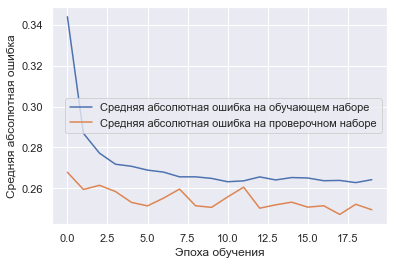

In [13]:
model = Sequential()

model.add(Dense(32, input_shape=(x.shape[1],), activation="relu"))
model.add(Dropout(0.5))

model.add(Dense(1, activation="linear"))

model.compile(optimizer=Adam(learning_rate=1/2**10), loss='mse', metrics=['mae'])

history = model.fit(
    x[:50000],
    y[:50000],
    epochs=20,
    batch_size=128,
    validation_data=(x[50000:], y[50000:]))

plt.plot(history.history['mae'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя абсолютная ошибка')
plt.legend()
plt.show()

In [15]:
pred = model.predict(x[50000:], verbose=False)
err = np.mean(abs(salaryScaler.inverse_transform(pred) - salaryScaler.inverse_transform(y[50000:])))
print(f"Средняя ошибка: {round(err,0)}")

In [16]:
gc.collect()
gc.collect()

maxWords = 10000
texts = df["Опыт (двойное нажатие для полной версии)"].fillna("unknown")
tokenizer = Tokenizer(num_words=maxWords, oov_token="unknown")
tokenizer.fit_on_texts(texts)

In [18]:
sequences = tokenizer.texts_to_sequences(texts)
maxLen = 500
sequences = pad_sequences(sequences, maxlen=maxLen, padding='post', truncating='post')

Epoch 1/20
391/391 [==============================] - 3s 7ms/step - loss: 1.1799 - mae: 0.2995 - val_loss: 0.1107 - val_mae: 0.2151
Epoch 2/20
391/391 [==============================] - 2s 6ms/step - loss: 1.0832 - mae: 0.2320 - val_loss: 0.0897 - val_mae: 0.1961
Epoch 3/20
391/391 [==============================] - 2s 6ms/step - loss: 1.0456 - mae: 0.2100 - val_loss: 0.0833 - val_mae: 0.1786
Epoch 4/20
391/391 [==============================] - 2s 6ms/step - loss: 1.0201 - mae: 0.1958 - val_loss: 0.0805 - val_mae: 0.1711
Epoch 5/20
391/391 [==============================] - 2s 6ms/step - loss: 1.0032 - mae: 0.1861 - val_loss: 0.0774 - val_mae: 0.1767
Epoch 6/20
391/391 [==============================] - 2s 6ms/step - loss: 0.9835 - mae: 0.1771 - val_loss: 0.0688 - val_mae: 0.1585
Epoch 7/20
391/391 [==============================] - 2s 6ms/step - loss: 0.9838 - mae: 0.1708 - val_loss: 0.0695 - val_mae: 0.1539
Epoch 8/20
391/391 [==============================] - 2s 6ms/step - loss: 0.

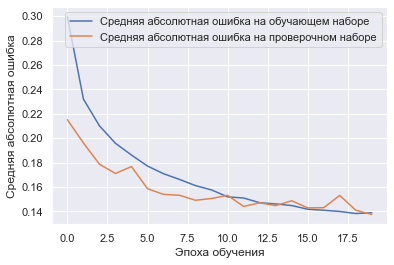

Средняя ошибка: 17861.0


In [19]:
gc.collect()
gc.collect()

model = Sequential()

model.add(Embedding(maxWords, 128, input_length=maxLen))
model.add(SpatialDropout1D(0.3))
model.add(Dropout(0.3))
model.add(Conv1D(32, 500, strides=1))
model.add(SpatialDropout1D(0.3))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(16, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(1, activation="linear"))

model.compile(optimizer=RMSprop(learning_rate=1/2**10), loss='mse', metrics=['mae'])

history = model.fit(
    sequences[:50000],
    y[:50000],
    epochs=20,
    batch_size=128,
    validation_data=(sequences[50000:], y[50000:])
    )

plt.plot(history.history['mae'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя абсолютная ошибка')
plt.legend()
plt.show()
pred = model.predict(sequences[50000:], verbose=False)
err = np.mean(abs(salaryScaler.inverse_transform(pred) - salaryScaler.inverse_transform(y[50000:])))
print(f"Средняя ошибка: {round(err,0)}")

In [20]:
texts = df["Ищет работу на должность:"]
tokenizer_2 = Tokenizer(num_words=maxWords, oov_token="unknown")
tokenizer_2.fit_on_texts(texts)
sequences_2 = tokenizer.texts_to_sequences(texts)

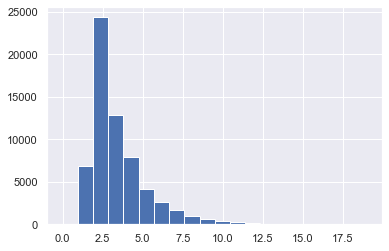

In [21]:
plt.hist([len(i) for i in sequences_2], bins=20)
plt.show()

In [22]:
maxLen_2 = 6
sequences_2 = pad_sequences(sequences_2, maxlen=maxLen_2, padding='post', truncating='post')

Epoch 1/20
391/391 [==============================] - 3s 5ms/step - loss: 1.1189 - mae: 0.2760 - val_loss: 0.1411 - val_mae: 0.2441
Epoch 2/20
391/391 [==============================] - 2s 5ms/step - loss: 1.1005 - mae: 0.2597 - val_loss: 0.1361 - val_mae: 0.2361
Epoch 3/20
391/391 [==============================] - 2s 4ms/step - loss: 1.0948 - mae: 0.2547 - val_loss: 0.1324 - val_mae: 0.2388
Epoch 4/20
391/391 [==============================] - 2s 4ms/step - loss: 1.0919 - mae: 0.2533 - val_loss: 0.1307 - val_mae: 0.2330
Epoch 5/20
391/391 [==============================] - 2s 4ms/step - loss: 1.0868 - mae: 0.2497 - val_loss: 0.1299 - val_mae: 0.2377
Epoch 6/20
391/391 [==============================] - 2s 5ms/step - loss: 1.0846 - mae: 0.2487 - val_loss: 0.1304 - val_mae: 0.2318
Epoch 7/20
391/391 [==============================] - 2s 4ms/step - loss: 1.0842 - mae: 0.2474 - val_loss: 0.1300 - val_mae: 0.2394
Epoch 8/20
391/391 [==============================] - 2s 4ms/step - loss: 1.

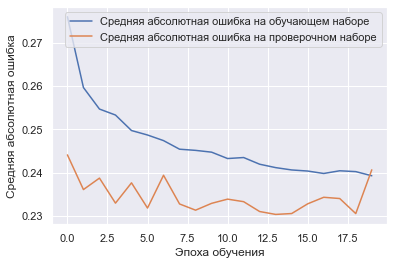

Средняя ошибка: 31272.0


In [23]:
gc.collect()
gc.collect()

model = Sequential()

model.add(Embedding(maxWords, 128, input_length=maxLen_2))
model.add(SpatialDropout1D(0.3))
model.add(Dropout(0.3))
model.add(Conv1D(128, 6, strides=1))
model.add(SpatialDropout1D(0.3))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(16, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(1, activation="linear"))

model.compile(optimizer=RMSprop(learning_rate=1/2**10), loss='mse', metrics=['mae'])

history = model.fit(
    sequences_2[:50000],
    y[:50000],
    epochs=20,
    batch_size=128,
    validation_data=(sequences_2[50000:], y[50000:])
    )

plt.plot(history.history['mae'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя абсолютная ошибка')
plt.legend()
plt.show()
pred = model.predict(sequences_2[50000:], verbose=False)
err = np.mean(abs(salaryScaler.inverse_transform(pred) - salaryScaler.inverse_transform(y[50000:])))
print(f"Средняя ошибка: {round(err,0)}")

In [41]:
def on_epoch_end(epoch, logs):
    pred = model.predict([x[50000:], sequences[50000:], sequences_2[50000:]], verbose=False)
    err = np.mean(abs(salaryScaler.inverse_transform(pred) - salaryScaler.inverse_transform(y[50000:])))
    print("\nЭпоха", epoch, "средняя ошибка", round(err,0))
    
printMae = LambdaCallback(on_epoch_end=on_epoch_end)

gc.collect()
gc.collect()
epochs = 50
batch_size = 256

input1 = Input((x.shape[1],))
input2 = Input((sequences.shape[1],))
input3 = Input((sequences_2.shape[1],))

x1 = Dense(32, activation="relu")(input1)
x1 = Dropout(0.5)(x1)


x2 = Embedding(maxWords, 128)(input2)
x2 = SpatialDropout1D(0.3)(x2)
x2 = Dropout(0.3)(x2)
x2 = Conv1D(32, 500, strides=1)(x2)
x2 = SpatialDropout1D(0.3)(x2)
x2 = Dropout(0.3)(x2)
x2 = Flatten()(x2)


x3 = Embedding(maxWords, 128)(input3)
x3 = SpatialDropout1D(0.3)(x3)
x3 = Dropout(0.3)(x3)
x3 = Conv1D(32, 6, strides=1)(x3)
x3 = SpatialDropout1D(0.3)(x3)
x3 = Dropout(0.3)(x3)
x3 = Flatten()(x3)


X = concatenate([x1, x2, x3])
X = Dense(32, activation='relu')(X)
X = Dense(1, activation='linear')(X)

model = Model((input1, input2, input3), X)

model.compile(optimizer=RMSprop(learning_rate=1/2**10), loss='mse', metrics=['mae'])

history = model.fit([x[:50000], sequences[:50000], sequences_2[:50000]], 
                    y[:50000], 
                    epochs=epochs,
                    batch_size=batch_size, 
                    validation_data=([x[50000:], sequences[50000:], sequences_2[50000:]], 
                      y[50000:]), 
                    callbacks = [printMae],
                    verbose=1)

model.compile(optimizer=RMSprop(learning_rate=1/2**11), loss='mse', metrics=['mae'])

history = model.fit([x[:50000], sequences[:50000], sequences_2[:50000]], 
                    y[:50000], 
                    epochs=epochs,
                    batch_size=batch_size, 
                    validation_data=([x[50000:], sequences[50000:], sequences_2[50000:]], 
                      y[50000:]), 
                    callbacks = [printMae],
                    verbose=1)

model.compile(optimizer=RMSprop(learning_rate=1/2**12), loss='mse', metrics=['mae'])

history = model.fit([x[:50000], sequences[:50000], sequences_2[:50000]], 
                    y[:50000], 
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=([x[50000:], sequences[50000:], sequences_2[50000:]],
                      y[50000:]),
                    callbacks = [printMae],
                    verbose=1)

model.compile(optimizer=RMSprop(learning_rate=1/2**13), loss='mse', metrics=['mae'])

history = model.fit([x[:50000], sequences[:50000], sequences_2[:50000]], 
                    y[:50000], 
                    epochs=epochs,
                    batch_size=batch_size, 
                    validation_data=([x[50000:], sequences[50000:], sequences_2[50000:]], 
                      y[50000:]), 
                    callbacks = [printMae],
                    verbose=1)

Epoch 1/50
192/196 [============================>.] - ETA: 0s - loss: 1.1530 - mae: 0.2692
Эпоха 0 средняя ошибка 25209.0
196/196 [==============================] - 4s 15ms/step - loss: 1.1350 - mae: 0.2680 - val_loss: 0.0810 - val_mae: 0.1940
Epoch 2/50
193/196 [============================>.] - ETA: 0s - loss: 1.0318 - mae: 0.1819
Эпоха 1 средняя ошибка 23319.0
196/196 [==============================] - 2s 12ms/step - loss: 1.0203 - mae: 0.1817 - val_loss: 0.0693 - val_mae: 0.1795
Epoch 3/50
191/196 [============================>.] - ETA: 0s - loss: 0.9916 - mae: 0.1602
Эпоха 2 средняя ошибка 20200.0
196/196 [==============================] - 2s 13ms/step - loss: 0.9707 - mae: 0.1600 - val_loss: 0.0642 - val_mae: 0.1555
Epoch 4/50
194/196 [============================>.] - ETA: 0s - loss: 0.9366 - mae: 0.1495
Эпоха 3 средняя ошибка 19938.0
196/196 [==============================] - 3s 13ms/step - loss: 0.9305 - mae: 0.1494 - val_loss: 0.0605 - val_mae: 0.1534
Epoch 5/50
191/196 [====

Epoch 35/50
191/196 [============================>.] - ETA: 0s - loss: 0.1397 - mae: 0.0853
Эпоха 34 средняя ошибка 15040.0
196/196 [==============================] - 2s 13ms/step - loss: 0.1370 - mae: 0.0853 - val_loss: 0.0460 - val_mae: 0.1158
Epoch 36/50
192/196 [============================>.] - ETA: 0s - loss: 0.1380 - mae: 0.0840
Эпоха 35 средняя ошибка 14760.0
196/196 [==============================] - 3s 13ms/step - loss: 0.1363 - mae: 0.0841 - val_loss: 0.0464 - val_mae: 0.1136
Epoch 37/50
194/196 [============================>.] - ETA: 0s - loss: 0.0473 - mae: 0.0823
Эпоха 36 средняя ошибка 14676.0
196/196 [==============================] - 3s 13ms/step - loss: 0.0471 - mae: 0.0823 - val_loss: 0.0467 - val_mae: 0.1129
Epoch 38/50
192/196 [============================>.] - ETA: 0s - loss: 0.0442 - mae: 0.0812
Эпоха 37 средняя ошибка 14974.0
196/196 [==============================] - 3s 14ms/step - loss: 0.0437 - mae: 0.0811 - val_loss: 0.0489 - val_mae: 0.1152
Epoch 39/50
195/

Epoch 19/50
193/196 [============================>.] - ETA: 0s - loss: 0.0854 - mae: 0.0648
Эпоха 18 средняя ошибка 13617.0
196/196 [==============================] - 3s 13ms/step - loss: 0.0845 - mae: 0.0647 - val_loss: 0.0460 - val_mae: 0.1048
Epoch 20/50
196/196 [==============================] - ETA: 0s - loss: 0.0392 - mae: 0.0653
Эпоха 19 средняя ошибка 13717.0
196/196 [==============================] - 3s 13ms/step - loss: 0.0392 - mae: 0.0653 - val_loss: 0.0447 - val_mae: 0.1056
Epoch 21/50
192/196 [============================>.] - ETA: 0s - loss: 0.0202 - mae: 0.0634
Эпоха 20 средняя ошибка 13609.0
196/196 [==============================] - 3s 13ms/step - loss: 0.0200 - mae: 0.0634 - val_loss: 0.0452 - val_mae: 0.1047
Epoch 22/50
195/196 [============================>.] - ETA: 0s - loss: 0.0232 - mae: 0.0640
Эпоха 21 средняя ошибка 13309.0
196/196 [==============================] - 2s 13ms/step - loss: 0.0231 - mae: 0.0640 - val_loss: 0.0439 - val_mae: 0.1024
Epoch 23/50
193/

Epoch 36/50
194/196 [============================>.] - ETA: 0s - loss: 0.0446 - mae: 0.0543
Эпоха 35 средняя ошибка 12902.0
196/196 [==============================] - 3s 15ms/step - loss: 0.0445 - mae: 0.0544 - val_loss: 0.0444 - val_mae: 0.0993
Epoch 37/50
196/196 [==============================] - ETA: 0s - loss: 0.0390 - mae: 0.0545
Эпоха 36 средняя ошибка 12785.0
196/196 [==============================] - 3s 13ms/step - loss: 0.0390 - mae: 0.0545 - val_loss: 0.0442 - val_mae: 0.0984
Epoch 38/50
192/196 [============================>.] - ETA: 0s - loss: 0.0307 - mae: 0.0540
Эпоха 37 средняя ошибка 12984.0
196/196 [==============================] - 3s 13ms/step - loss: 0.0303 - mae: 0.0540 - val_loss: 0.0454 - val_mae: 0.0999
Epoch 39/50
191/196 [============================>.] - ETA: 0s - loss: 0.0378 - mae: 0.0545
Эпоха 38 средняя ошибка 12931.0
196/196 [==============================] - 3s 13ms/step - loss: 0.0372 - mae: 0.0545 - val_loss: 0.0455 - val_mae: 0.0995
Epoch 40/50
192/

Epoch 20/50
196/196 [==============================] - ETA: 0s - loss: 0.0148 - mae: 0.0507
Эпоха 19 средняя ошибка 12641.0
196/196 [==============================] - 3s 13ms/step - loss: 0.0148 - mae: 0.0507 - val_loss: 0.0438 - val_mae: 0.0973
Epoch 21/50
192/196 [============================>.] - ETA: 0s - loss: 0.0219 - mae: 0.0515
Эпоха 20 средняя ошибка 12712.0
196/196 [==============================] - 3s 15ms/step - loss: 0.0216 - mae: 0.0515 - val_loss: 0.0438 - val_mae: 0.0978
Epoch 22/50
191/196 [============================>.] - ETA: 0s - loss: 0.0598 - mae: 0.0516
Эпоха 21 средняя ошибка 12717.0
196/196 [==============================] - 3s 15ms/step - loss: 0.0586 - mae: 0.0516 - val_loss: 0.0443 - val_mae: 0.0979
Epoch 23/50
194/196 [============================>.] - ETA: 0s - loss: 0.0522 - mae: 0.0517
Эпоха 22 средняя ошибка 12718.0
196/196 [==============================] - 3s 14ms/step - loss: 0.0519 - mae: 0.0517 - val_loss: 0.0445 - val_mae: 0.0979
Epoch 24/50
192/